# Combustion analysis in a coal-fired power plant

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.signal import find_peaks
import statsmodels.api as sm
import seaborn as sns

In [2]:
DATA_FILE = "a08r.mat"
ARRAY_NAME = "a08r"
SPS = 8192 # Samples per second

### findMaximum
Funkcja służąca do wyszukiwanie punktów maksimum w otrzymanych danych

Parametry:
- data: dataFrame z danymi, cały niezmodyfikowany
- column: nazwa kolumny w której chcemy szukać
- width: minimalna szerokość (x) piku
- distance: minimlna odległość (x) pomiędzy szukanymi punktami
- threshold: minimlna/maksymalna odległość (y) pomiędzy szukanymi punktami
- prominence: eeee, to nie wiem, ale czasami jak większe to pomaga eliminować podwójne punkty
  
Zwraca listę z punktami maksimum


In [3]:
def findMaximums(data: pd.DataFrame, column: str, width: int = 10, distance: int = SPS*45, threshold: list = None, prominence: float = 0.1) -> list:
    """Funkcja służąca do wyszukiwanie punktów maksimum w otrzymanych danych

    Args:
        data (pd.DataFrame): dataFrame z danymi, cały niezmodyfikowany
        column (str): nazwa kolumny w której chcemy szukać
        width (int, optional): minimalna szerokość (x) piku. Defaults to 10.
        distance (int, optional): minimlna odległość (x) pomiędzy szukanymi punktami. Defaults to SPS*45.
        threshold (list, optional): minimlna/maksymalna odległość (y) pomiędzy szukanymi punktami. Defaults to None.
        prominence (float, optional): eeee, to nie wiem, ale czasami jak większe to pomaga eliminować podwójne punkty. Defaults to 0.1.

    Returns:
        list: Zwraca listę z punktami maksimum
    """
    ret = []
    ret = find_peaks(data[column], width=width, distance=distance, threshold=threshold, prominence=prominence)[0].tolist()
    return ret  

### dataSplit
Funkcja służąca do podziału danych na podzbiory, według podanej listy podziału. Przykładowo dla punktów podziału 1, 2, 3, zwraca przedziały [1, 2], [2, 3]

Parametry:
- data: dataFrame z danymi, cały niezmodyfikowany
- spliter: lista, wykorzystywana do podziału
- channel: nazwa kanału, który ma zostać zpisany, `all` jeżeli wszystkie
  
Zwraca dataFrame z przedziałami

In [4]:
def dataSplit(data: pd.DataFrame, spliter: list, channel: str = "all") -> (pd.DataFrame, list):
    """Funkcja służąca do podziału danych na podzbiory, według podanej listy podziału. Przykładowo dla punktów podziału 1, 2, 3, zwraca przedziały [1, 2], [2, 3]

    Args:
        data (pd.DataFrame): dataFrame z danymi, cały niezmodyfikowany
        spliter (list): lista, wykorzystywana do podziału
        channel (str): nazwa kanału, który ma zostać zpisany, `all` jeżeli wszystkie

    Returns:
        pd.DataFrame: Zwraca dataFrame z przedziałami
    """
    ret = pd.DataFrame()
    num_of_buckets = len(spliter) - 1
    keys = [f"bucket{i}" for i in range(num_of_buckets)]
    tmp = []
    
    if "all" == channel:
        for item in range(num_of_buckets):
            tmp.append(data[spliter[item]:(spliter[item + 1] - 1)])
        ret = pd.concat(tmp, keys=keys)
        
    elif channel in data.columns:
        for item in range(num_of_buckets):
            tmp.append(data[channel][spliter[item]:(spliter[item + 1] - 1)])
        ret = pd.concat(tmp, keys=keys)
        
    else:
        ret = None
        
    return ret, keys

In [5]:
def descriptiveStats(bucket: pd.Series) -> dict:
    """Function generates descriptive statistic from given data

    Args:
        bucket (pd.Series): data to generate statistics

    Returns:
        dict: statistics
    """
    ret = dict.fromkeys(["mean", "median", "min", "min_idx" "max", "max_idx", "std", "var", "auto_corr", "roll_mean"])
    
    ret["mean"] = bucket.mean()
    ret["median"] = bucket.median()
    ret["min"] = bucket.min()
    ret["min_idx"] = bucket.idxmin()
    ret["max"] = bucket.max()
    ret["max_idx"] = bucket.idxmax()
    ret["std"] = bucket.std()
    ret["var"] = bucket.var()
    ret["auto_corr"] = pd.Series(sm.tsa.acf(bucket, nlags=bucket.size), index=range(bucket.first_valid_index(), bucket.last_valid_index() + 1))
    ret["roll_mean"] = bucket.rolling(SPS).mean()
        
    return ret

In [6]:
def drawDescriptiveStats(bucket: pd.Series, name: str, stats: dict, size_x: int, size_y: int) -> None:
    """Function draws plot of descriptive statistics

    Args:
        bucket (pd.Series): data to draw statistics
        name (str): title of a plot
        stats (dict): descriptive statistics
        size_x (int): horizontal size of a plot
        size_y (int): vertical size of a plot
    """
    plt.figure(figsize=(size_x, size_y))
    plt.title(name)
    plt.plot(bucket, label="Data")
    plt.plot(stats["roll_mean"], label="1s mean")
    plt.plot(stats["auto_corr"], label="Auto Corr", color="greenyellow")
    plt.hlines(stats["mean"], xmin=bucket.first_valid_index(), xmax=bucket.last_valid_index(), label="Mean", color="magenta")
    plt.hlines(stats["median"], xmin=bucket.first_valid_index(), xmax=bucket.last_valid_index(), label="Median", color="royalblue")
    plt.plot(stats["min_idx"], stats["min"], "o", color="aqua", label="Minimum")
    plt.plot(stats["max_idx"], stats["max"], "o", color="crimson", label="Maximum")
    plt.plot([], [], ' ', label=f"""Standard deviation: {round(stats["std"], 2)}""")
    plt.plot([], [], ' ', label=f"""Variance: {round(stats["var"], 2)}""")
    plt.legend()
    plt.show()

In [37]:
def removeConstComp(data: pd.Series, method: str = "mean", window: int = SPS) -> pd.Series:
    """Function to remove contant component from pandas data series

    Args:
        data (pd.Series): data to remove constant component
        method (str): method of removal (mean, roll, diff)
        window (int): window size used in rolling method

    Returns:
        pd.Series: data 
    """
    ret = pd.Series()
    
    match method:
        case "mean":
            mean = data.mean()
            ret = data.sub(mean)    
        case "roll":
            rolling = data.rolling(window).mean()
            mean = data[0: rolling.first_valid_index() - 1].mean()
            rolling = rolling.fillna(mean)
            ret = data.sub(rolling)
        case "diff":
            ret = data.diff()
            
        
    return ret

/tmp/ipykernel_27440/1087966352.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ret = pd.Series()
/tmp/ipykernel_27440/1087966352.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ret = pd.Series()
/tmp/ipykernel_27440/1087966352.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ret = pd.Series()


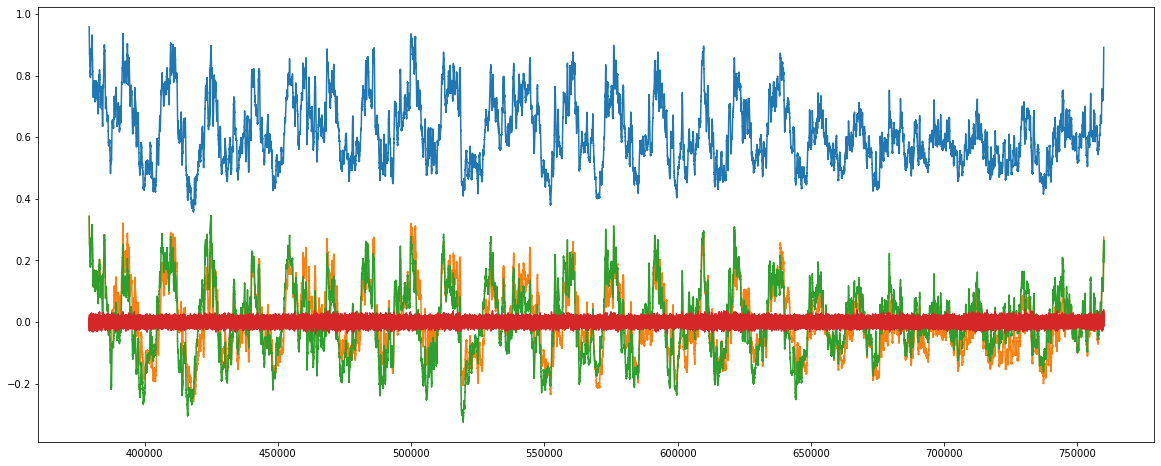

In [38]:
if __name__ == "__main__":
    
    data = pd.DataFrame(loadmat(DATA_FILE)[ARRAY_NAME], columns=(["ch1", "ch2", "ch3", "ch4", "ch5"]))
    
    maximums_a08r_ch5 = findMaximums(data, "ch5", prominence=0.4)    
    splited_df, keys = dataSplit(data, maximums_a08r_ch5, "all")
    
    new_data = removeConstComp(splited_df["ch5"]["bucket0"], "mean")
    new_data1 = removeConstComp(splited_df["ch5"]["bucket0"], "roll")
    new_data2 = removeConstComp(splited_df["ch5"]["bucket0"], "diff")
    
    plt.figure(figsize=(20, 8))
    plt.plot(splited_df["ch5"]["bucket0"])
    plt.plot(new_data)
    plt.plot(new_data1)
    plt.plot(new_data2)
    plt.show()